* 구동 PC 환경 : Ryzen 3700x, Geforce 1660 Super, Windows 10, python 3.9

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install missingno
!pip install catboost
!pip install optuna

from IPython.display import clear_output 
clear_output()

In [2]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# progress bar in repeated code
from tqdm import tqdm
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import seaborn as sns
import missingno as msno

# Scoring
from sklearn.metrics import f1_score

# Model
import catboost

#### seed fix

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

### Data Load

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [5]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


#### feature 타입 변경

In [6]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')
test['LINE'] = test['LINE'].astype('category')

#### 모델에 영향력을 주지 못할 feature 제거

In [7]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique()==0 or len(train_df[x].unique())==1: # nan 이거나 모두 같은 값인 경우
            train_df.drop(columns=[x], inplace=True)
    return train_df

train = remove_col(train)

In [8]:
train_x, train_y = train.drop(columns=['Y_Class', 'PRODUCT_ID', 'TIMESTAMP', 'Y_Quality']), train['Y_Class']
test = test[train_x.columns]

In [9]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


### Y_Class

In [10]:
train_y.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### 결측치 대체

#### Missingno

<AxesSubplot:>

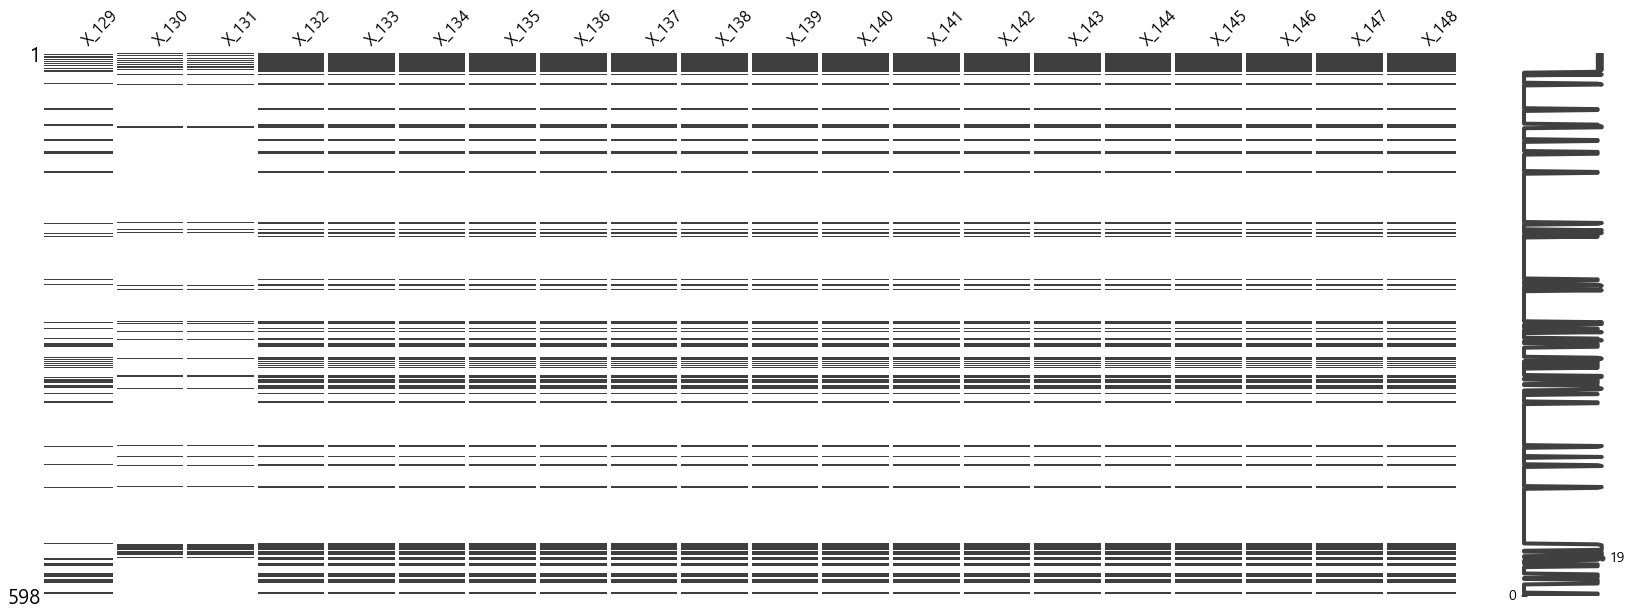

In [11]:
# 20개의 열만 뽑아 확인해 보았는데도 결측치가 굉장히 많다.
msno.matrix(train_x[train_x.columns[130:150]])

#### fillna(0)

* Catboost는 nan을 'string' 타입으로 치환하여 학습을 진행할 수 있다. 따라서 fillna(0)와 유사한 성능이 나타난다.
* MiceImputer, SimpleImputer 등 다양한 방법들을 활용해 보았지만, 성능향상에 도움이 되지 않았다.

In [12]:
train_x[train_x.columns[2:]] = train_x[train_x.columns[2:]].fillna(0)
test[test.columns[2:]] = test[test.columns[2:]].fillna(0)

<AxesSubplot:>

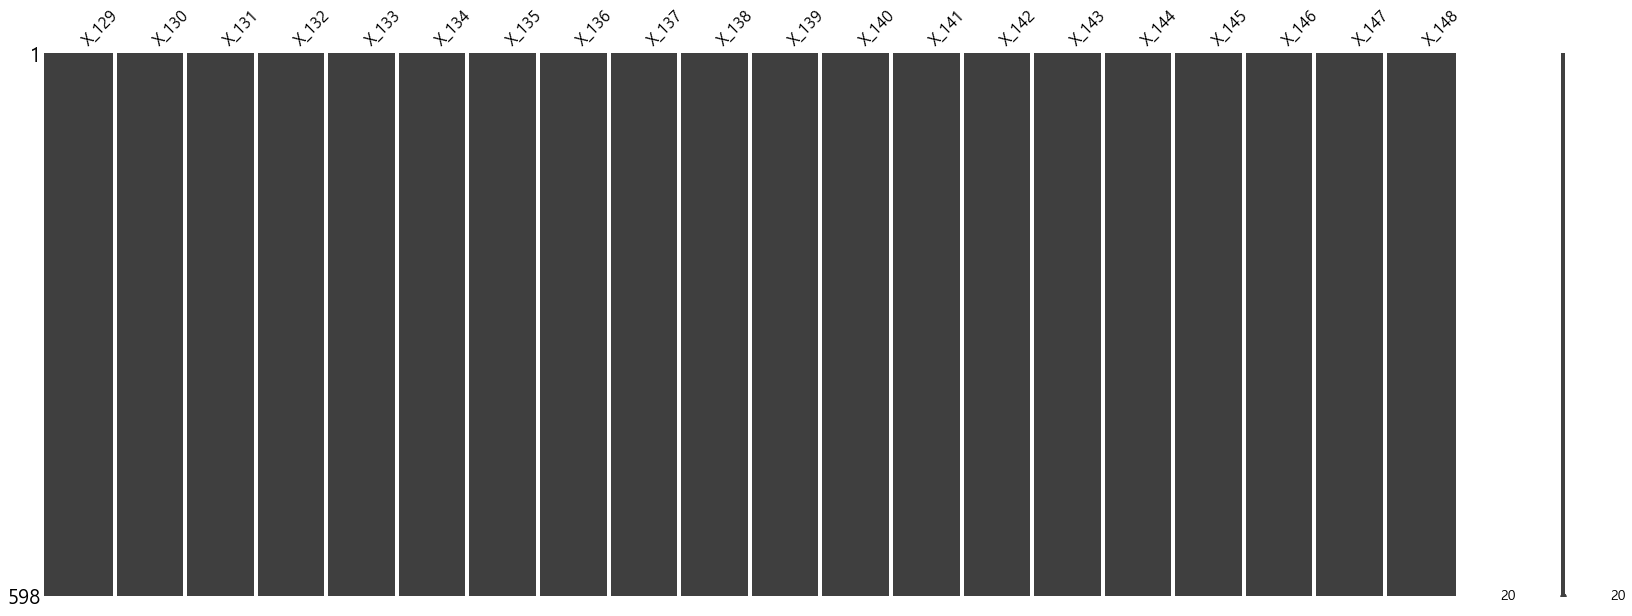

In [13]:
# 결측치를 모두 0으로 대체한 후
msno.matrix(train_x[train_x.columns[130:150]])

In [14]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,0.0
1,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,0.0
2,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,0.0
3,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,0.0
4,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,0.0,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.00,0.0
594,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,168.7,384.0,369.811321,353.0,49.47,53.07,50.89,55.10,66.49,1.0
595,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.6,383.0,367.018868,352.0,0.00,0.00,0.00,0.00,0.00,1.0
596,T100304,O_31,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.00,0.0


### Feature importance

* Feature Importance는 학습된 모델에서 주로 사용된 컬럼들을 나타내기 때문에, 학습에 도움이 되지 않은 컬럼을 지워준다고 해도 
test predict에 영향력이 적다. 또한, 줄어든 컬럼으로 학습 방식이 바뀌고, overfit을 완화하여 더 나은 결과를 유도할 수 있다.

* Permutation Importance는 train_x에서 분할된 validation_set을 학습한 모델에서의 영향력을 보여주는 지표이다.
 validation set은 train으로부터 분리된 영역이므로 train에서의 영향력을 대변한다고 할 수 있다.
 문제는 train에서는 여러 값이 존재하는 컬럼이 test에서는 nan만 존재하는 컬럼일 수 있으므로 test set에서의 영향력을 판단하기 어렵다.
 그래서 permutation importance는 활용하지 않는다.



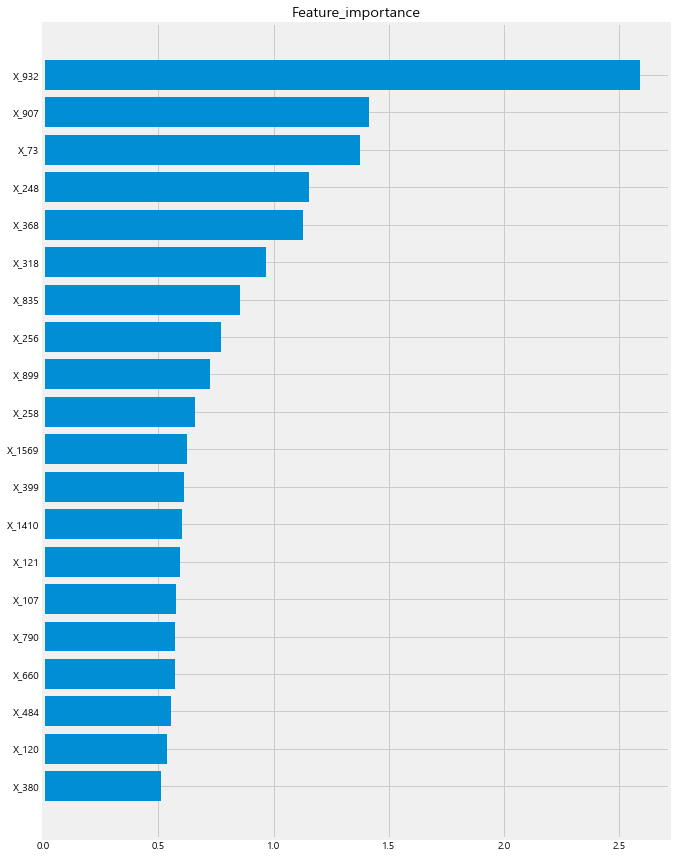

In [15]:
feat_list = []
for _ in range(1):
    clf = catboost.CatBoostClassifier(verbose=0, thread_count=5) # task_type='GPU'
    clf.fit(train_x, train_y, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

    feat_list.append(clf.feature_importances_)

feat_list = np.array(feat_list)
feat_max = np.array([max(feat_list[:, i]) for i in range(len(feat_list[0]))])
feature_imp = pd.Series(feat_max, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()
# train_x = train_x[train_x.columns[feat_max>0]]
# test = test[train_x.columns]

# Visualization
plt.rcParams["figure.figsize"] = (10, 15)

plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()

In [16]:
# 시도할 때마다 컬럼 수의 차이가 있다. 따라서 이 곳에 저장한 컬럼을 활용한다.
feat_max = ["X_1", "X_2", "X_7", "X_8", "X_11", "X_12", "X_13", "X_19", "X_20", "X_21", "X_22", "X_24", "X_38", "X_41", "X_43", "X_44", "X_45", "X_48", "X_51", "X_53", "X_54", "X_58", "X_61", "X_63", "X_65", "X_72", "X_73", "X_90", "X_96", "X_97", "X_98", "X_101", "X_102", "X_103", "X_105", "X_106", "X_107", "X_109", "X_110", "X_111", "X_117", "X_118", "X_119", "X_120", "X_121", "X_123", "X_124", "X_125", "X_126", "X_127", "X_129", "X_130", "X_131", "X_136", "X_139", "X_141", "X_146", "X_149", "X_178", "X_189", "X_216", "X_218", "X_223", "X_225", "X_240", "X_242", "X_243", "X_247", "X_248", "X_256", "X_257", "X_258", "X_261", "X_265", "X_266", "X_267", "X_279", "X_285", "X_286", "X_287", "X_289", "X_294", "X_297", "X_303", "X_304", "X_306", "X_307", "X_308", "X_318", "X_332", "X_335", "X_337", "X_338", "X_339", "X_344", "X_345", "X_346", "X_348", "X_350", "X_353", "X_354", "X_356", "X_358", "X_364", "X_366", "X_367", "X_368", "X_370", "X_371", "X_372", "X_373", "X_374", "X_379", "X_380", "X_385", "X_386", "X_387", "X_388", "X_389", "X_393", "X_394", "X_395", "X_396", "X_397", "X_398", "X_399", "X_400", "X_401", "X_402", "X_403", "X_404", "X_405", "X_407", "X_408", "X_412", "X_413", "X_415", "X_416", "X_419", "X_420", "X_421", "X_422", "X_423", "X_428", "X_435", "X_436", "X_437", "X_438", "X_439", "X_440", "X_442", "X_443", "X_445", "X_446", "X_447", "X_448", "X_449", "X_451", "X_452", "X_453", "X_454", "X_455", "X_456", "X_457", "X_458", "X_459", "X_460", "X_461", "X_462", "X_463", "X_465", "X_468", "X_469", "X_471", "X_473", "X_474", "X_475", "X_476", "X_477", "X_478", "X_482", "X_483", "X_484", "X_485", "X_489", "X_490", "X_491", "X_492", "X_493", "X_494", "X_495", "X_496", "X_497", "X_498", "X_499", "X_500", "X_501", "X_502", "X_506", "X_507", "X_510", "X_511", "X_513", "X_514", "X_515", "X_516", "X_517", "X_518", "X_520", "X_521", "X_523", "X_524", "X_525", "X_527", "X_528", "X_530", "X_531", "X_533", "X_534", "X_535", "X_536", "X_537", "X_538", "X_539", "X_540", "X_541", "X_543", "X_544", "X_545", "X_546", "X_547", "X_549", "X_550", "X_552", "X_553", "X_554", "X_555", "X_556", "X_557", "X_559", "X_560", "X_562", "X_565", "X_566", "X_568", "X_570", "X_571", "X_572", "X_573", "X_574", "X_577", "X_578", "X_581", "X_582", "X_584", "X_585", "X_586", "X_587", "X_594", "X_595", "X_596", "X_597", "X_604", "X_608", "X_611", "X_613", "X_614", "X_615", "X_616", "X_618", "X_619", "X_621", "X_622", "X_623", "X_624", "X_627", "X_628", "X_632", "X_643", "X_644", "X_645", "X_646", "X_647", "X_648", "X_649", "X_651", "X_652", "X_653", "X_654", "X_655", "X_656", "X_658", "X_659", "X_660", "X_661", "X_662", "X_663", "X_665", "X_667", "X_668", "X_669", "X_670", "X_671", "X_674", "X_675", "X_677", "X_678", "X_679", "X_681", "X_682", "X_686", "X_687", "X_688", "X_690", "X_696", "X_697", "X_698", "X_700", "X_701", "X_703", "X_704", "X_705", "X_706", "X_707", "X_708", "X_709", "X_710", "X_711", "X_712", "X_713", "X_714", "X_716", "X_717", "X_718", "X_719", "X_720", "X_721", "X_722", "X_725", "X_726", "X_727", "X_728", "X_731", "X_733", "X_734", "X_735", "X_736", "X_739", "X_741", "X_742", "X_744", "X_745", "X_746", "X_747", "X_748", "X_751", "X_752", "X_753", "X_754", "X_757", "X_758", "X_762", "X_763", "X_766", "X_767", "X_768", "X_769", "X_771", "X_772", "X_774", "X_775", "X_780", "X_781", "X_783", "X_785", "X_786", "X_788", "X_789", "X_790", "X_792", "X_793", "X_795", "X_796", "X_802", "X_804", "X_808", "X_810", "X_811", "X_813", "X_814", "X_815", "X_816", "X_817", "X_819", "X_820", "X_821", "X_822", "X_824", "X_825", "X_827", "X_830", "X_831", "X_832", "X_834", "X_835", "X_837", "X_838", "X_841", "X_845", "X_848", "X_852", "X_853", "X_854", "X_855", "X_856", "X_861", "X_863", "X_864", "X_870", "X_871", "X_875", "X_876", "X_877", "X_878", "X_882", "X_883", "X_884", "X_885", "X_890", "X_891", "X_892", "X_893", "X_894", "X_895", "X_896", "X_897", "X_898", "X_899", "X_901", "X_907", "X_909", "X_911", "X_914", "X_915", "X_916", "X_918", "X_919", "X_921", "X_922", "X_923", "X_924", "X_925", "X_926", "X_927", "X_928", "X_929", "X_930", "X_931", "X_932", "X_938", "X_939", "X_940", "X_941", "X_942", "X_943", "X_944", "X_947", "X_948", "X_949", "X_954", "X_955", "X_956", "X_957", "X_958", "X_959", "X_960", "X_961", "X_963", "X_964", "X_965", "X_966", "X_967", "X_968", "X_972", "X_973", "X_975", "X_976", "X_977", "X_978", "X_979", "X_980", "X_981", "X_982", "X_983", "X_984", "X_985", "X_986", "X_991", "X_993", "X_994", "X_995", "X_996", "X_998", "X_999", "X_1000", "X_1001", "X_1002", "X_1010", "X_1012", "X_1014", "X_1015", "X_1016", "X_1017", "X_1018", "X_1026", "X_1029", "X_1030", "X_1032", "X_1038", "X_1040", "X_1041", "X_1043", "X_1044", "X_1047", "X_1048", "X_1050", "X_1053", "X_1055", "X_1058", "X_1059", "X_1061", "X_1063", "X_1065", "X_1067", "X_1068", "X_1072", "X_1073", "X_1074", "X_1075", "X_1076", "X_1078", "X_1079", "X_1080", "X_1081", "X_1082", "X_1084", "X_1089", "X_1094", "X_1095", "X_1096", "X_1098", "X_1099", "X_1104", "X_1105", "X_1106", "X_1107", "X_1108", "X_1109", "X_1110", "X_1111", "X_1112", "X_1113", "X_1114", "X_1116", "X_1117", "X_1118", "X_1120", "X_1123", "X_1129", "X_1131", "X_1133", "X_1135", "X_1138", "X_1143", "X_1147", "X_1150", "X_1152", "X_1153", "X_1154", "X_1155", "X_1156", "X_1158", "X_1159", "X_1160", "X_1162", "X_1163", "X_1164", "X_1166", "X_1168", "X_1169", "X_1170", "X_1172", "X_1175", "X_1176", "X_1179", "X_1182", "X_1183", "X_1185", "X_1189", "X_1190", "X_1191", "X_1192", "X_1193", "X_1194", "X_1196", "X_1197", "X_1199", "X_1202", "X_1203", "X_1204", "X_1205", "X_1207", "X_1208", "X_1210", "X_1211", "X_1212", "X_1213", "X_1214", "X_1215", "X_1217", "X_1220", "X_1221", "X_1222", "X_1223", "X_1224", "X_1225", "X_1226", "X_1227", "X_1228", "X_1229", "X_1231", "X_1232", "X_1233", "X_1235", "X_1238", "X_1240", "X_1241", "X_1242", "X_1243", "X_1244", "X_1245", "X_1257", "X_1258", "X_1260", "X_1262", "X_1263", "X_1265", "X_1266", "X_1267", "X_1269", "X_1271", "X_1272", "X_1273", "X_1274", "X_1275", "X_1277", "X_1279", "X_1280", "X_1281", "X_1286", "X_1288", "X_1289", "X_1290", "X_1291", "X_1292", "X_1294", "X_1295", "X_1296", "X_1297", "X_1300", "X_1301", "X_1305", "X_1306", "X_1310", "X_1315", "X_1321", "X_1322", "X_1323", "X_1324", "X_1327", "X_1329", "X_1330", "X_1331", "X_1332", "X_1333", "X_1334", "X_1335", "X_1336", "X_1337", "X_1338", "X_1339", "X_1341", "X_1342", "X_1343", "X_1344", "X_1345", "X_1346", "X_1347", "X_1348", "X_1350", "X_1351", "X_1352", "X_1353", "X_1354", "X_1356", "X_1357", "X_1358", "X_1359", "X_1365", "X_1366", "X_1368", "X_1369", "X_1370", "X_1371", "X_1372", "X_1373", "X_1374", "X_1375", "X_1376", "X_1379", "X_1380", "X_1381", "X_1382", "X_1384", "X_1386", "X_1387", "X_1388", "X_1389", "X_1390", "X_1391", "X_1398", "X_1400", "X_1401", "X_1402", "X_1403", "X_1404", "X_1405", "X_1406", "X_1408", "X_1409", "X_1410", "X_1411", "X_1412", "X_1414", "X_1415", "X_1416", "X_1418", "X_1419", "X_1420", "X_1422", "X_1423", "X_1424", "X_1425", "X_1427", "X_1428", "X_1430", "X_1437", "X_1439", "X_1442", "X_1443", "X_1444", "X_1445", "X_1446", "X_1447", "X_1448", "X_1449", "X_1450", "X_1459", "X_1462", "X_1466", "X_1469", "X_1472", "X_1473", "X_1476", "X_1477", "X_1478", "X_1479", "X_1482", "X_1483", "X_1485", "X_1486", "X_1488", "X_1489", "X_1490", "X_1492", "X_1494", "X_1495", "X_1497", "X_1498", "X_1499", "X_1500", "X_1501", "X_1505", "X_1506", "X_1508", "X_1510", "X_1511", "X_1512", "X_1513", "X_1515", "X_1516", "X_1517", "X_1518", "X_1521", "X_1526", "X_1527", "X_1530", "X_1532", "X_1534", "X_1538", "X_1539", "X_1542", "X_1543", "X_1544", "X_1545", "X_1546", "X_1548", "X_1551", "X_1552", "X_1553", "X_1554", "X_1556", "X_1557", "X_1558", "X_1560", "X_1561", "X_1562", "X_1563", "X_1565", "X_1566", "X_1567", "X_1568", "X_1569", "X_1570", "X_1583", "X_1584", "X_1586", "X_1587", "X_1589", "X_1591", "X_1602", "X_1607", "X_1608", "X_1609", "X_1611", "X_1612", "X_1613", "X_1614", "X_1615", "X_1616", "X_1617", "X_1619", "X_1621", "X_1622", "X_1625", "X_1631", "X_1632", "X_1633", "X_1634", "X_1636", "X_1638", "X_1639", "X_1640", "X_1641", "X_1642", "X_1643", "X_1646", "X_1647", "X_1649", "X_1651", "X_1652", "X_1653", "X_1655", "X_1663", "X_1664", "X_1665", "X_1667", "X_1669", "X_1670", "X_1679", "X_1694", "X_1696", "X_1697", "X_1705", "X_1706", "X_1712", "X_1714", "X_1715", "X_1716", "X_1718", "X_1725", "X_1726", "X_1732", "X_1734", "X_1735", "X_1736", "X_1737", "X_1738", "X_1740", "X_1743", "X_1744", "X_1747", "X_1748", "X_1750", "X_1751", "X_1756", "X_1757", "X_1763", "X_1768", "X_1770", "X_1774", "X_1776", "X_1780", "X_1781", "X_1782", "X_1787", "X_1788", "X_1791", "X_1792", "X_1794", "X_1804", "X_1806", "X_1812", "X_1813", "X_1814", "X_1817", "X_1818", "X_1820", "X_1821", "X_1822", "X_1824", "X_1826", "X_1830", "X_1833", "X_1834", "X_1849", "X_1850", "X_1854", "X_1856", "X_1866", "X_1874", "X_1880", "X_1906", "X_1917", "X_1925", "X_1927", "X_1928", "X_1931", "X_1933", "X_1936", "X_1939", "X_1945", "X_1946", "X_1947", "X_1948", "X_1949", "X_1952", "X_1953", "X_1954", "X_1955", "X_1956", "X_1958", "X_1959", "X_1965", "X_1966", "X_1976", "X_1980", "X_1981", "X_1984", "X_1992", "X_1993", "X_2010", "X_2018", "X_2019", "X_2024", "X_2026", "X_2027", "X_2028", "X_2029", "X_2032", "X_2034", "X_2036", "X_2040", "X_2041", "X_2042", "X_2044", "X_2046", "X_2047", "X_2048", "X_2050", "X_2051", "X_2058", "X_2061", "X_2062", "X_2063", "X_2064", "X_2066", "X_2068", "X_2070", "X_2071", "X_2077", "X_2079", "X_2080", "X_2084", "X_2085", "X_2092", "X_2095", "X_2096", "X_2099", "X_2100", "X_2102", "X_2104", "X_2105", "X_2120", "X_2131", "X_2142", "X_2152", "X_2158", "X_2159", "X_2183", "X_2184", "X_2190", "X_2191", "X_2198", "X_2208", "X_2210", "X_2214", "X_2222", "X_2225", "X_2226", "X_2231", "X_2236", "X_2242", "X_2247", "X_2253", "X_2266", "X_2272", "X_2273", "X_2286", "X_2293", "X_2309", "X_2310", "X_2326", "X_2339", "X_2340", "X_2344", "X_2346", "X_2347", "X_2354", "X_2361", "X_2364", "X_2372", "X_2378", "X_2387", "X_2396", "X_2407", "X_2408", "X_2409", "X_2412", "X_2415", "X_2423", "X_2427", "X_2428", "X_2431", "X_2432", "X_2434", "X_2436", "X_2438", "X_2440", "X_2442", "X_2446", "X_2449", "X_2455", "X_2464", "X_2467", "X_2470", "X_2477", "X_2479", "X_2481", "X_2497", "X_2509", "X_2531", "X_2533", "X_2535", "X_2542", "X_2543", "X_2552", "X_2553", "X_2555", "X_2559", "X_2561", "X_2562", "X_2566", "X_2595", "X_2602", "X_2611", "X_2618", "X_2621", "X_2700", "X_2701", "X_2703", "X_2705", "X_2706", "X_2708", "X_2711", "X_2712", "X_2715", "X_2717", "X_2719", "X_2720", "X_2722", "X_2724", "X_2728", "X_2735", "X_2739", "X_2741", "X_2742", "X_2743", "X_2744", "X_2745", "X_2747", "X_2761", "X_2765", "X_2771", "X_2778", "X_2779", "X_2780", "X_2781", "X_2783", "X_2785", "X_2788", "X_2790", "X_2791", "X_2793", "X_2794", "X_2797", "X_2800", "X_2801", "X_2803", "X_2810", "X_2817", "X_2822", "X_2825", "X_2830", "X_2836", "X_2837", "X_2839", "X_2840", "X_2841", "X_2845", "X_2846", "X_2848", "X_2849", "X_2850", "X_2851", "X_2853", "X_2854", "X_2856", "X_2858", "X_2859", "X_2860", "X_2861", "X_2862", "X_2864", "X_2865", "X_2866", "X_2867", "X_2868"]
train_x = train_x[feat_max]
test = test[feat_max]

# 영향력이 있는 모든 컬럼 출력
for c in train_x.columns:
    print(f'"{c}"', end=', ')

"X_1", "X_2", "X_7", "X_8", "X_11", "X_12", "X_13", "X_19", "X_20", "X_21", "X_22", "X_24", "X_38", "X_41", "X_43", "X_44", "X_45", "X_48", "X_51", "X_53", "X_54", "X_58", "X_61", "X_63", "X_65", "X_72", "X_73", "X_90", "X_96", "X_97", "X_98", "X_101", "X_102", "X_103", "X_105", "X_106", "X_107", "X_109", "X_110", "X_111", "X_117", "X_118", "X_119", "X_120", "X_121", "X_123", "X_124", "X_125", "X_126", "X_127", "X_129", "X_130", "X_131", "X_136", "X_139", "X_141", "X_146", "X_149", "X_178", "X_189", "X_216", "X_218", "X_223", "X_225", "X_240", "X_242", "X_243", "X_247", "X_248", "X_256", "X_257", "X_258", "X_261", "X_265", "X_266", "X_267", "X_279", "X_285", "X_286", "X_287", "X_289", "X_294", "X_297", "X_303", "X_304", "X_306", "X_307", "X_308", "X_318", "X_332", "X_335", "X_337", "X_338", "X_339", "X_344", "X_345", "X_346", "X_348", "X_350", "X_353", "X_354", "X_356", "X_358", "X_364", "X_366", "X_367", "X_368", "X_370", "X_371", "X_372", "X_373", "X_374", "X_379", "X_380", "X_385", 

In [17]:
train_x

,X_1,X_2,X_7,X_8,X_11,X_12,X_13,X_19,X_20,X_21,...,X_2858,X_2859,X_2860,X_2861,X_2862,X_2864,X_2865,X_2866,X_2867,X_2868
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,131.646667,115.4,209.0,197.286667,189.0,368.296296,353.0,39.34,40.89,32.56
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,128.748276,119.7,198.0,193.296552,185.6,367.735849,353.0,38.89,42.82,43.92
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.365517,104.0,193.4,179.820690,165.5,367.320755,353.0,39.19,36.65,42.47
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,112.082759,94.5,190.3,181.920690,165.8,369.188679,353.0,37.74,39.17,52.17
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,138.066667,109.7,208.6,196.393333,182.6,367.351852,352.0,38.70,41.89,46.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,2.0,95.0,50.0,10.0,468.9,473.9,459.2,250.0,527.0,538.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.00
594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159.527586,144.2,198.3,180.810345,168.7,369.811321,353.0,49.47,53.07,50.89
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,178.248276,159.6,186.5,176.486207,156.6,367.018868,352.0,0.00,0.00,0.00
596,40.0,94.0,45.0,10.0,505.8,510.9,497.1,250.0,489.0,498.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.00


### 모델 학습

In [18]:
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU")
clf.fit(train_x, train_y)
pred = clf.predict(test)

In [19]:
subm['Y_Class'] = pred
subm.Y_Class.value_counts()

1    261
0     37
2     12
Name: Y_Class, dtype: int64

In [20]:
# subm.to_csv('./submission.csv', index=False)

### 저장된 모델 활용

In [21]:
clf = catboost.CatBoostClassifier()

In [22]:
# clf.save_model('model.cbm', format='cbm')
clf.load_model('model.cbm')
clf.fit(train_x, train_y)
pred = clf.predict(test)

In [23]:
subm['Y_Class'] = pred
subm.Y_Class.value_counts()

1    270
0     36
2      4
Name: Y_Class, dtype: int64

* 1660s Catboost GPU 학습 기준, private 점수로 0.693를 도출해냄